# Image Denoising With Iterated Conditional Modes

In this exercise you will implement image denoising with iterated conditional modes (ICM) on an Ising model.

For reading image files, this code requires the Python Pillow package.

The following cell provides some useful functionality.

In [250]:
from PIL import Image           # pillow
import numpy as np
from matplotlib import pyplot as plt
from numpy.random import default_rng
rng = default_rng()


def readImg(imgname):
    img = np.asarray(Image.open(imgname + '.png'), dtype=np.float64)[:,:,0]
    off = (np.max(img) - np.min(img)) / 2
    img -= off
    img /= off
    return img  # matrix containing values -1 and 1


def perturbNormal(img, sigma):
    return img + rng.normal(size=img.shape, scale=sigma)

def perturbFlip(img, frac):
    imgNoisy = np.copy(img)
    imgNoisy[rng.uniform(0, 1, size=img.shape) < frac] *= -1
    return imgNoisy


def showImg(img):
    plt.imshow(img, cmap='gray')

def showImgs(clean, noisy):
    fig, (axClean, axNoisy) = plt.subplots(1,2)
    axClean.imshow(clean, cmap='gray')
    axClean.set_title=('Clean Image')
    axNoisy.imshow(noisy, cmap='gray')
    axNoisy.set_title=('Noisy Image')

Create and display your noisy image here:

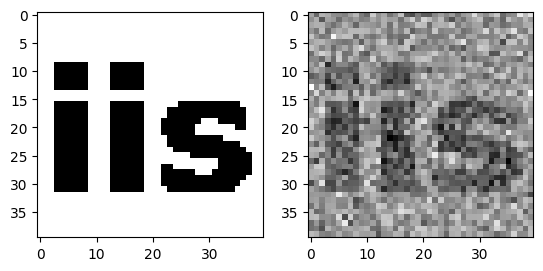

In [251]:
img = readImg('iis')                          # also try other images
if True:                                      # set to True or False to choose your noise
    imgNoisy = perturbNormal(img, 1)          # 2nd arg is standard deviation of noise
else:
    imgNoisy = perturbFlip(img, 0.2)          # 2nd arg is proportion of flipped pixels
    
showImgs(img, imgNoisy)

In our specific Ising model (Slide 10; cf. Bishop PRML Eqns. 8.42 and 8.43 and Slide 34),
$$
\begin{align}
p(\mathbf{z}, \mathbf{x}) &= \frac{1}{Z} \exp(-E(\mathbf{z}, \mathbf{x})) \\
E(\mathbf{z}, \mathbf{x}) &= h \sum_i z_i - \beta \sum_{\{i,j\}} z_i z_j - \eta \sum_i z_i x_i
\end{align}
$$
where $\{i,j\}$ includes all pairs of *adjacent* nodes.

The ICM algorithm proceeds as follows (Bishop PRML Sec. 8.3.3):
  1. for all $i$ set $z_i \leftarrow x_i$
  2. repeat until convergence:
     1. for all $i$:
        1. for $v \in \{+1, -1\}$ evaluate $E(z_i = v) = E(\mathbf{z}, \mathbf{x})$ with all $z_{j\neq i} $ and $x_j$ unchanged
        2. set $z_i \leftarrow \displaystyle\mathop{\textrm{argmin}}_{v \in \{+1, -1\}} E(z_i = v)$

Since the computation is done entirely by comparing energies, the joint probability $p(\mathbf{z}, \mathbf{x})$ does not need to be computed.

Implement your solution of `denoise_iter()` in the following code block.

In [252]:
# Returns a denoised version of the nparray img using ICM.
# img is a noisy version of a binary image; true pixel states are -1 or 1.
# h, beta, eta are as in Bishop PRML Eqn. 8.42.
def denoise(img, h=0, beta=1, eta=1, interim=False, show_end=True):
    imgDenoised = np.ones_like(img)
    imgDenoised[img < 0] = -1
    converged = False
    for iter in range(99):
        imgPrev = np.copy(imgDenoised)
        imgDenoised = denoise_iter(imgDenoised, img, h, beta, eta)
        if (imgDenoised == imgPrev).all():
            print(f'ICM done after {iter} iterations')
            converged = True
            break
        elif interim:
            plt.figure()
            showImg(imgDenoised)
    if not interim and show_end:
        showImg(imgDenoised)
    if not converged:
        print(f'ICM did not converge after 99 iterations')
    return imgDenoised

# Returns the result of one iteration of ICM.
# imgDenoised is the result of the previous iteration.
# The other arguments are as in denoise() above.
def denoise_iter(imgDenoised, img, h, beta, eta):
    ### BEGIN YOUR CODE HERE
    height, width = img.shape

    for i in range(height):
        for j in range(width):
            imgDenoised[i, j] = 1
            E_pos = compute_total_energy(imgDenoised, img, h, beta, eta)

            imgDenoised[i, j] = -1
            E_neg = compute_total_energy(imgDenoised, img, h, beta, eta)

            # Choose the one with the lower energy
            imgDenoised[i, j] = 1 if E_pos < E_neg else -1
    
    ### END YOUR CODE HERE
    return imgDenoised

def compute_total_energy(z, x, h, beta, eta):
    vertical_pairwise_products = z[:-1] * z[1:] # pixel * bottom neighbor
    horizontal_pairwise_products = z[:, :-1] * z[:, 1:] # pixel * right neighbor
    return h * np.sum(z) - beta * (np.sum(vertical_pairwise_products) + np.sum(horizontal_pairwise_products)) - eta * np.sum(z * x)


Now test your code:

ICM done after 3 iterations


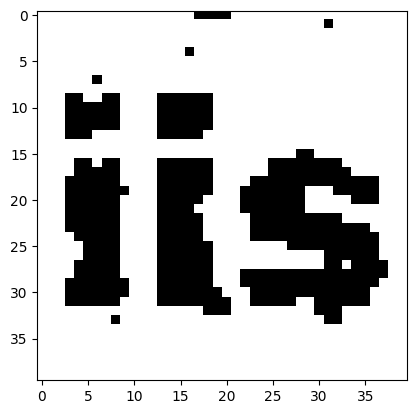

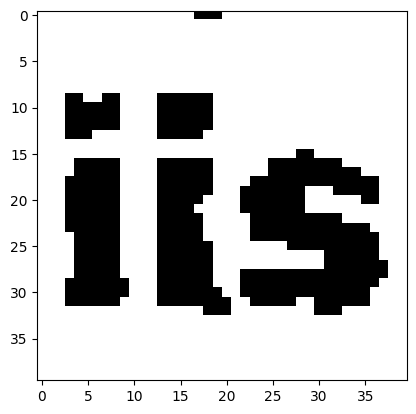

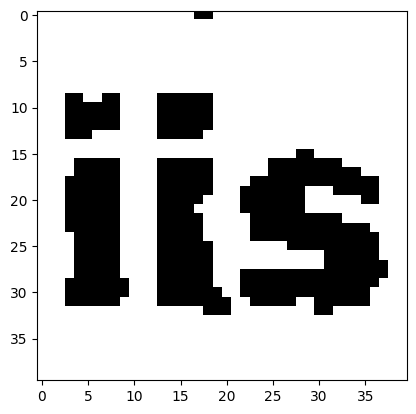

In [253]:
imgDenoised = denoise(imgNoisy, h=0, beta=1, eta=1, interim=True, show_end=True)

Play with three different representative settings of $h$ and (separately) with three different relative settings of $\beta$ and $\eta$ (you may leave $\beta$ alone). Explain your observations below, including illustrations generated with `denoise(..., interim=False)`.

## My Observations

ICM done after 5 iterations


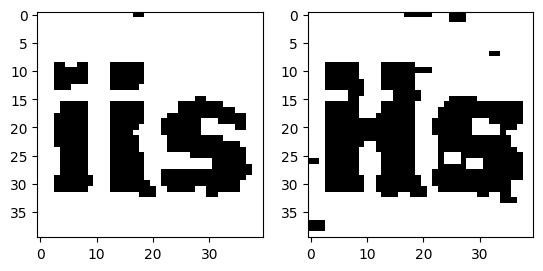

In [254]:
# Three different representative settings of h
# 1) h = 1
imgDenoised_h1 = denoise(imgNoisy, h=1, beta=1, eta=1, interim=False, show_end=False)
showImgs(imgDenoised, imgDenoised_h1)

1) When we set $h = 1$, we can see in the images above that we introduce a bias toward black pixels. This is because the term $h \sum_i z_i$ in $E(\mathbf{z}, \mathbf{x})$ now becomes relevant. By adding the sum over all pixel values to the energy function, we favor configurations where the total sum is smaller when minimizing the energy. Since black pixels correspond to $z_i = −1$, a smaller sum implies more black pixels than white ones. This explains why the final image contains significantly more black pixels.

ICM done after 10 iterations


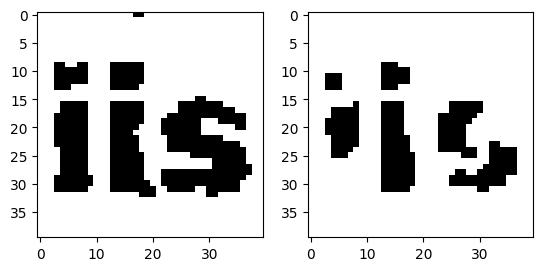

In [255]:
# Three different representative settings of h
# 2) h = -1
imgDenoised_h2 = denoise(imgNoisy, h=-1, beta=1, eta=1, interim=False, show_end=False)
showImgs(imgDenoised, imgDenoised_h2)

2) When we set $h = -1$, we observe the opposite effect: the resulting image contains more white pixels. Again, this is due to the term $h \sum z_i$ in $E(\mathbf{z}, \mathbf{x})$. With $h$ now negative, minimizing the energy favors a larger sum of $z_i$. Since white pixels correspond to $z_i = +1$, this results in a bias toward more white pixels than black ones.

ICM done after 3 iterations


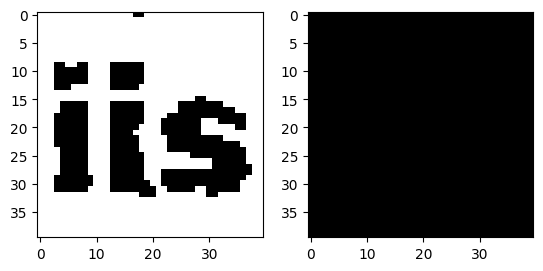

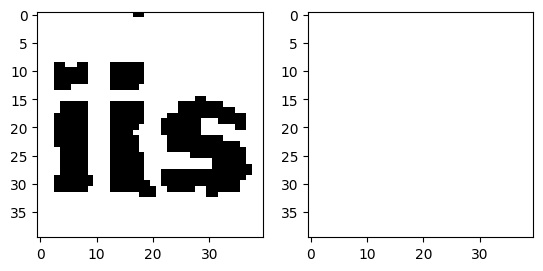

In [256]:
# Three different representative settings of h
# 3) h = -3
imgDenoised_h3 = denoise(imgNoisy, h=-3, beta=1, eta=1, interim=False, show_end=False)
showImgs(imgDenoised, imgDenoised_h3) # misleading visualization: matplotlib auto-scales colormap and incorrectly maps all 1s to black

# if we manually set vmin=-1 and vmax=1, then 1 is interpreted as white and -1 as black
fig, (axClean, axNoisy) = plt.subplots(1,2)
axClean.imshow(imgDenoised, cmap='gray', vmin=-1, vmax=1)
axNoisy.imshow(imgDenoised_h3, cmap='gray', vmin=-1, vmax=1)
plt.show()

3) With $h = -3$, the bias toward white pixels is so strong that all pixels in the denoised image become $+1$. However, due to matplotlib’s automatic colormap scaling, the image initially appears completely black. This happens because the visualization function does not manually set the grayscale range, causing all values of $+1$ to be incorrectly mapped to black. When `vmin = -1` and `vmax = 1` are set explicitly, the image is correctly displayed as entirely white.


ICM done after 24 iterations


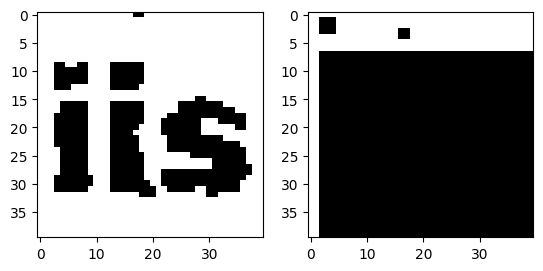

In [257]:
# Three different representative settings of eta
# 1) eta = 0
imgDenoised_eta1 = denoise(imgNoisy, h=0, beta=1, eta=0, interim=False, show_end=False)
showImgs(imgDenoised, imgDenoised_eta1)

1) When we set $\eta = 0$ (and again $h = 0$), the model completely ignores the noisy input. As a result, only the term in the energy function corresponding to the prior, $\beta \sum_{\{i,j\}} z_i z_j$, influences the denoised image. The result becomes entirely black (not always, due to convergence), because we are now minimizing only this term, which is lowest when all $z_i$ are equal to $-1$.



ICM done after 12 iterations
ICM done after 8 iterations


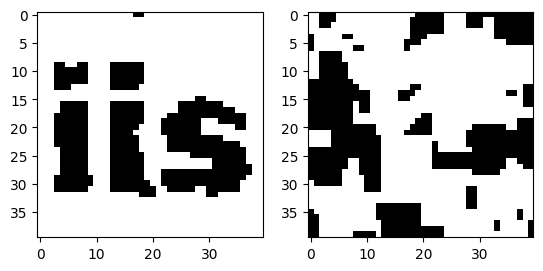

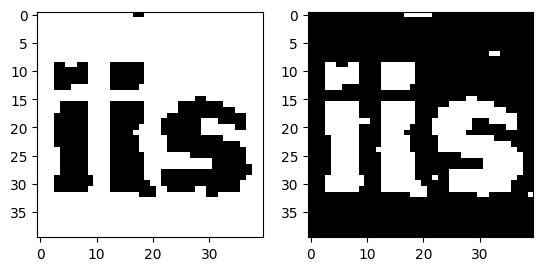

In [258]:
# Three different representative settings of eta
# 2) eta = -1 or -2
imgDenoised_eta2 = denoise(imgNoisy, h=0, beta=1, eta=-1, interim=False, show_end=False)
showImgs(imgDenoised, imgDenoised_eta2)
imgDenoised_eta2 = denoise(imgNoisy, h=0, beta=1, eta=-2, interim=False, show_end=False)
showImgs(imgDenoised, imgDenoised_eta2)

2) When we set $\eta = -1$, the model starts to favor configurations that contradict the noisy input. This is because the data term $- \eta \sum_i z_i x_i$ is now minimized when $z_i$ and $x_i$ have opposite signs. At $\eta = -1$, this anti-alignment is weak and results in a noisy, unstable image. When we decrease $\eta$ further to $\eta = -2$, the effect becomes more pronounced: the model strongly favors the opposite of the input and produces an inverted version of the original image.



ICM done after 5 iterations


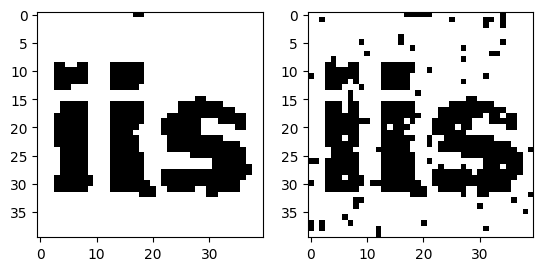

In [260]:
# Three different representative settings of eta
# 3) eta = 5
imgDenoised_eta3 = denoise(imgNoisy, h=0, beta=1, eta=5, interim=False, show_end=False)
showImgs(imgDenoised, imgDenoised_eta3)

3) When we set $\eta = 5$, the model places strong trust in the noisy input. The data term $- \eta \sum_i z_i x_i$ dominates the energy, causing the algorithm to closely follow the input pixels. This leads to visible holes in the letters and scattered black pixels in the background. The term in the energy function corresponding to the prior (controlled by $\beta$) is no longer strong enough to suppress these inconsistencies.
